<a href="https://colab.research.google.com/github/wprzadka/AdventOfCode/blob/main/09_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laboratorium 9. Wizja Komputerowa

**Uwaga:** Poniższy notebook jest stworzony z myślą o odpalaniu go w [Colaboratory](https://colab.research.google.com/), oznacza to, że przygotowane zadania zakładają uczenie modelu z użyciem GPU. Na zajęciach zostanie krótko omówione używanie Colaboratory. Na własną odpowiedzialność można używać własnego komputera do rozwiązania pracy domowej.

In [2]:
import torch
from torchvision.datasets import CIFAR10
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pickle

### CIFAR10
[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) to dataset zawierający 60 tysięcy kolorowych obrazków rozmiaru 32 $\times$ 32 pikseli należących do 10 różnych klas. Poniżej przykładowe wizualizacje.

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to .
CIFAR10 classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


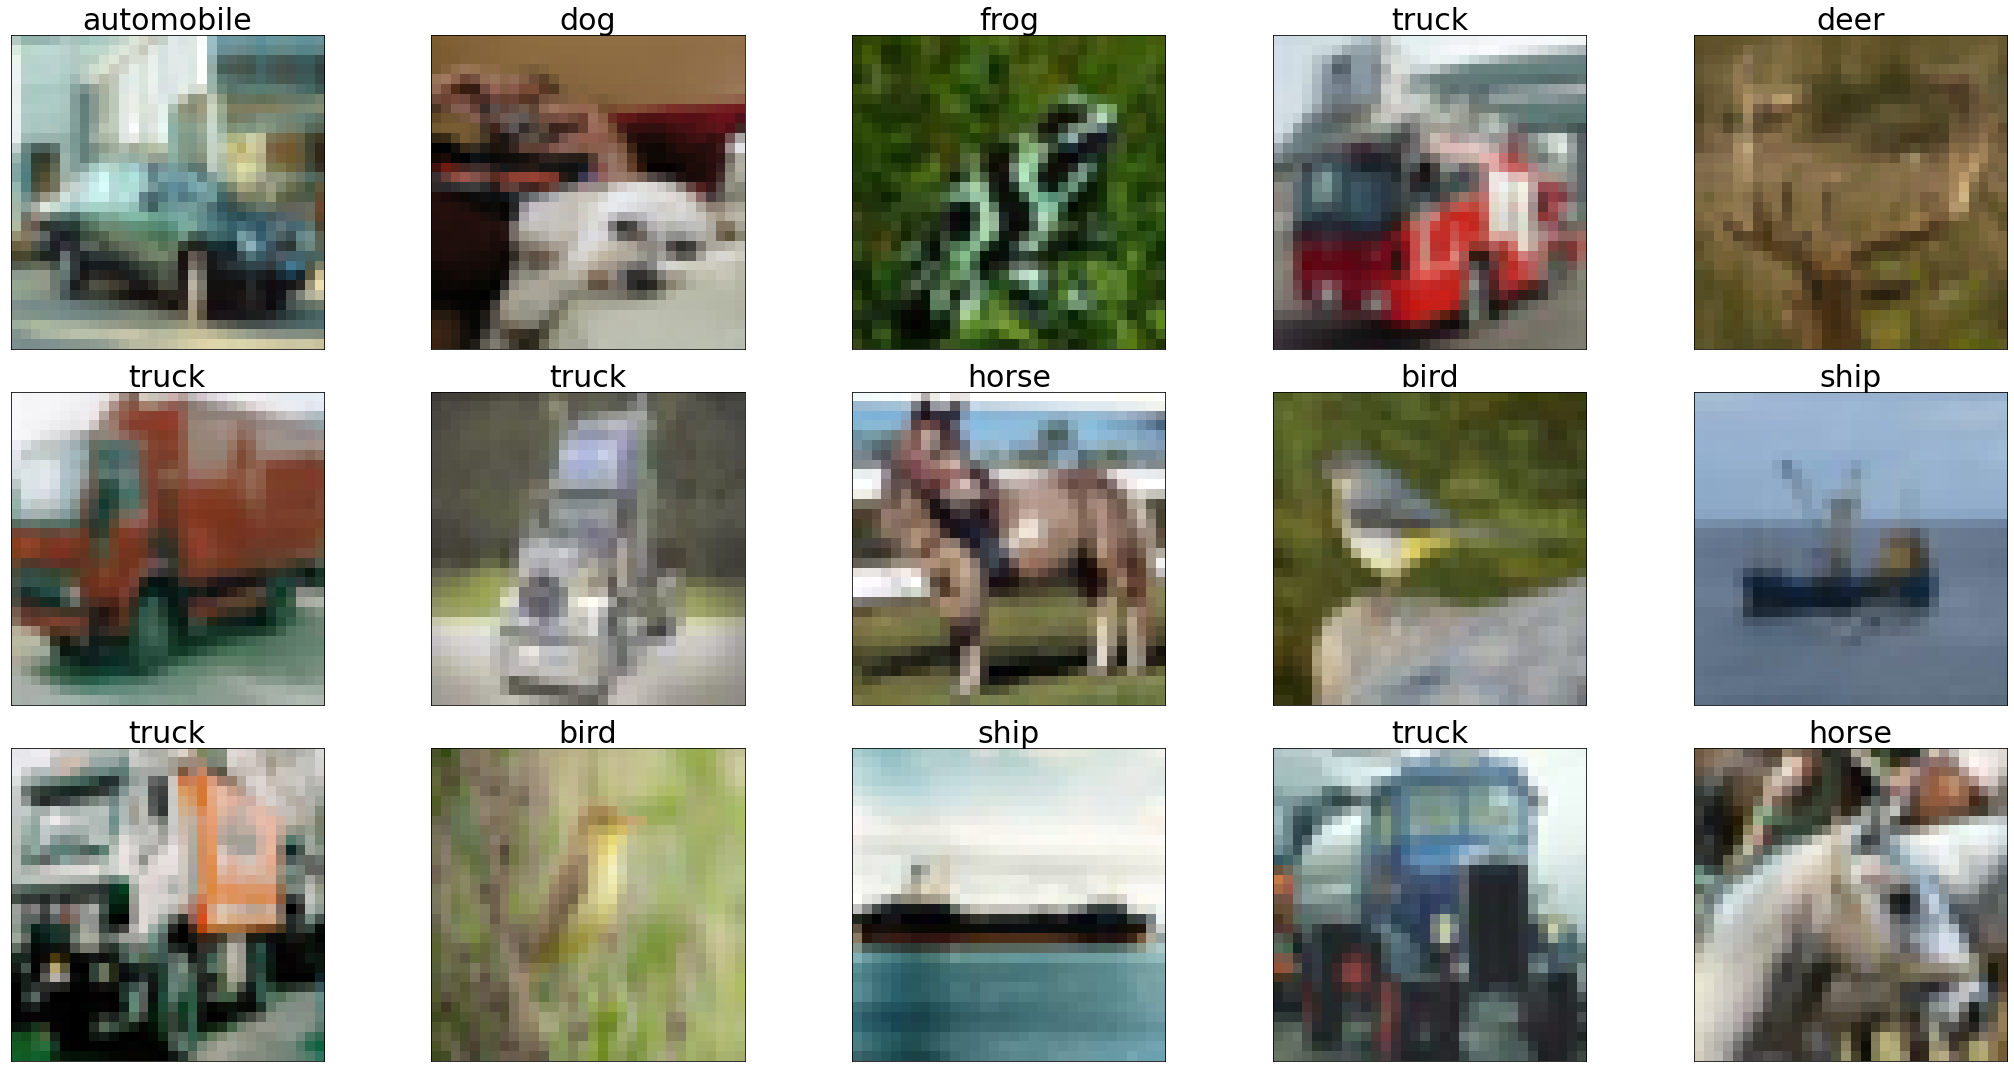

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = CIFAR10(root='.', train=True, transform=ToTensor(), download=True)
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# get a single batch
for x, y in loader:
    break

# prepare visualisations
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
        ind = 5 * i + j
        ax.imshow(np.transpose(x[ind], (1, 2, 0)))
        ax.set_title(f"{dataset.classes[y[ind]]}", fontdict={'size': 30})
        ax.set_xticks([])
        ax.set_yticks([])

fig.tight_layout()

print(f"CIFAR10 classes: {dataset.classes}")

### Zadanie 1. Sieć Konwolucyjna na CIFAR10 (4 pkt.)

Zadaniem jest zaimplementowanie "od zera" sieci konwolucyjnej do klasyfikacji wieloklasowej na zbiorze CIFAR10. Należy zaimplementować zarówno model jak i pętle uczenia oraz ewaluacji. Twój kod powinien raportować *loss* w trakcie trenowania, testowania oraz *accuracy* na zbiorze testowym (opcjonalnie również na treningowym). Na koniec *accuracy* powinno osiągnąć wynik powyżej 75% na zbiorze testowym. Można korzystać z dowolnych mechanizmów dostępnych w PyTorchu.

Porady do zadania:

* Zwiększenie treningowego *batch size* może przyspieszyć uczenie, ale należy pamiętać, że, tak jak każdy hiperparametr, *batch_size* ma wpływ na proces uczenia.
* Przy dobieraniu architektury bądź hiperparametrów nie testować dłużej niż kilka epok (około 5), tak aby mieć szybki feedback. Dopiero po dobraniu powyższych rzeczy puścić dłuższe uczenie. Warto przy okazji wizualizować krzywe uczenia (funkcji kosztu) aby zwrócić uwagę na to kiedy koszt zaczyna się "wypłaszczać" i czy model przypadkowo nie overfituje (patrząc na wartości kosztu na zbiorze testowym)
* Dodatkowe (nadobowiązkowe) rzeczy do poprawienia wyniku: LR Schedule, Early Stopping.

In [4]:
# tutaj zdefiniuj swój model, nie zapomnij podziedziczyć po torch.nn.Module
class CifarClassifier(torch.nn.Module):
  def __init__(self, batch_size=64):
    super(CifarClassifier, self).__init__()
    self.classes_num = 10

    self.layers = torch.nn.ModuleList([
                   torch.nn.Conv2d(3, 32, 3),
                   torch.nn.ReLU(),
                   torch.nn.Conv2d(32, 32, 3),
                   torch.nn.ReLU(),
                   torch.nn.Conv2d(32, 64, 3),
                   torch.nn.ReLU(),
                   torch.nn.MaxPool2d(2),
                   torch.nn.BatchNorm2d(64),


                   torch.nn.Conv2d(64, 64, 3),
                   torch.nn.ReLU(),
                   torch.nn.Conv2d(64, 64, 3),
                   torch.nn.ReLU(),
                   torch.nn.Conv2d(64, 64, 3),
                   torch.nn.ReLU(),
                   torch.nn.MaxPool2d(2),
                   torch.nn.BatchNorm2d(64),

                   torch.nn.Flatten(1),
                   torch.nn.Linear(576, 256),
                   torch.nn.ReLU(),

                   torch.nn.Linear(256, self.classes_num),
                   torch.nn.Softmax(dim=1)
    ])

  def forward(self, x):
    """
    x = self.conv(x)
    # print(conv_out)
    x = self.flatten(x)
    # print(flat_out.shape)
    x = self.full_con(x)
    y = self.softmax(x)
    # y = np.zeros(self.classes_num)
    # y[0] = 1
    """
    for layer in self.layers:
      x = layer(x)

    return x

In [5]:
# tutaj uzupełnij ładowanie danych treningowych i testowych
train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=ToTensor())

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=ToTensor())

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [6]:
# define model
classifier = CifarClassifier(batch_size)
classifier.to(device)
optimizer = torch.optim.Adam(params=classifier.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

In [7]:
MODEL_PATH = 'CifarClassifier'
METRICS_PATH = 'metrics.pkl'

In [164]:
# load saved state of model
classifier = CifarClassifier()
classifier.load_state_dict(torch.load(MODEL_PATH))
classifier.to(device)
classifier.train()

CifarClassifier(
  (layers): ModuleList(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (7): ReLU()
    (8): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=1600, out_features=512, bias=True)
    (14): ReLU()
    (15): Linear(in_features=512, out_features=10, bias=True)
    (16): Softmax(dim=1)
  )
)

In [165]:
# load saved metrics
with open(METRICS_PATH, "rb") as f:
  metrics = pickle.load(f)

In [166]:
torch.save(classifier.state_dict(), MODEL_PATH)
with open(METRICS_PATH, "wb") as f:
  pickle.dump(metrics, f)

In [9]:
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
patience = 5
early_stoping_triggers = 0
last_loss = float('inf')

training_finished = False
epochs_num = 50
epoch = 0

while not training_finished and epoch < epochs_num:
  epoch += 1

  train_accuracy = []
  train_loss = []
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    # evaluate
    output = classifier(x)
    loss = loss_func(output, y)
    # save metrics
    train_loss.append(loss)
    train_accuracy.append(torch.sum(torch.argmax(output, dim=1) == y) / train_loader.batch_size)
    # correct network
    loss.backward()
    optimizer.step()
  
  metrics['train_loss'].append(sum(train_loss) / len(train_loader))
  metrics['train_accuracy'].append(sum(train_accuracy) / len(train_loader))

  print(f'epoch: {epoch}')
  print(f'train accuracy: {metrics["train_accuracy"][-1]}')
 
  test_accuracy = []
  test_loss = []
  for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
      output = classifier(x)
      loss = loss_func(output, y)

      test_loss.append(loss)
      test_accuracy.append(torch.sum(torch.argmax(output, dim=1) == y) / test_loader.batch_size)

  metrics['test_loss'].append(sum(test_loss) / len(test_loader))
  metrics['test_accuracy'].append(sum(test_accuracy) / len(test_loader))

  print(f'test accuracy: {metrics["test_accuracy"][-1]}')

  if metrics['test_loss'][-1] > last_loss:
    early_stoping_triggers += 1
    if early_stoping_triggers > patience:
      training_finished = True
  else:
    early_stoping_triggers = 0
  last_loss = metrics['test_loss'][-1]

  if epoch % 5 == 0:
    torch.save(classifier.state_dict(), MODEL_PATH)
    with open(METRICS_PATH, "wb") as f:
      pickle.dump(metrics, f)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 1
train accuracy: 0.4381393790245056
test accuracy: 0.46779996156692505
epoch: 2
train accuracy: 0.5155251026153564
test accuracy: 0.5476999878883362
epoch: 3
train accuracy: 0.5615009665489197
test accuracy: 0.5541000366210938
epoch: 4
train accuracy: 0.5910925269126892
test accuracy: 0.599299967288971
epoch: 5
train accuracy: 0.6165281534194946
test accuracy: 0.6133999824523926
epoch: 6
train accuracy: 0.6355498433113098
test accuracy: 0.632099986076355
epoch: 7
train accuracy: 0.6505754590034485
test accuracy: 0.6365000009536743
epoch: 8
train accuracy: 0.6654012203216553
test accuracy: 0.6665999889373779
epoch: 9
train accuracy: 0.6761308908462524
test accuracy: 0.6612999439239502
epoch: 10
train accuracy: 0.6854619383811951
test accuracy: 0.6660000085830688
epoch: 11
train accuracy: 0.6943933963775635
test accuracy: 0.6832000017166138
epoch: 12
train accuracy: 0.7041040658950806
test accuracy: 0.6796000003814697
epoch: 13
train accuracy: 0.7073609232902527
test accuracy: 0.

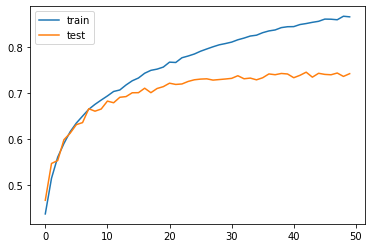

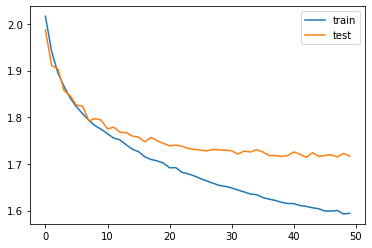

In [10]:
plt.plot(metrics['train_accuracy'], label='train')
plt.plot(metrics['test_accuracy'], label='test')
plt.title='accuracy'
plt.legend()
plt.show()

plt.plot(metrics['train_loss'], label='train')
plt.plot(metrics['test_loss'], label='test')
plt.title='loss'
plt.legend()
plt.show()

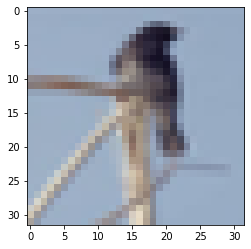

airplane: 0.0%, automobile: 0.0%, bird: 100.0%, cat: 0.0%, deer: 0.0%, dog: 0.0%, frog: 0.0%, horse: 0.0%, ship: 0.0%, truck: 0.0%



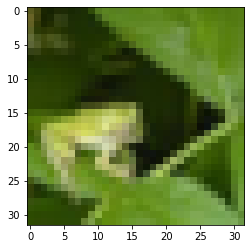

airplane: 16.4%, automobile: 0.0%, bird: 0.0%, cat: 83.6%, deer: 0.0%, dog: 0.0%, frog: 0.0%, horse: 0.0%, ship: 0.0%, truck: 0.0%



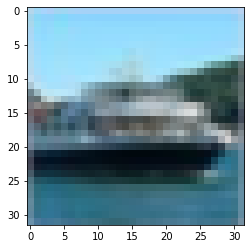

airplane: 66.3%, automobile: 0.0%, bird: 0.0%, cat: 33.7%, deer: 0.0%, dog: 0.0%, frog: 0.0%, horse: 0.0%, ship: 0.0%, truck: 0.0%



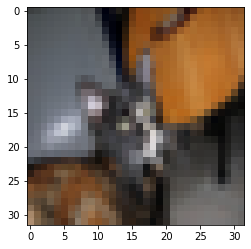

airplane: 99.4%, automobile: 0.0%, bird: 0.0%, cat: 0.0%, deer: 0.6%, dog: 0.0%, frog: 0.0%, horse: 0.0%, ship: 0.0%, truck: 0.0%



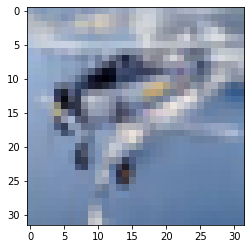

airplane: 100.0%, automobile: 0.0%, bird: 0.0%, cat: 0.0%, deer: 0.0%, dog: 0.0%, frog: 0.0%, horse: 0.0%, ship: 0.0%, truck: 0.0%



In [11]:
img_loader = DataLoader(dataset, batch_size=1, shuffle=True)
iterator = iter(img_loader)

classifier.to('cpu')
for _ in range(5):
  x, _ = next(iterator)
  plt.imshow(np.transpose(x[0], (1, 2, 0)))
  plt.xticks = []
  plt.ytics = []
  plt.show()
  print(f"{', '.join([f'{a}: {b*100:.1f}%' for a, b in zip(dataset.classes, classifier(x)[0])])}\n")


# fig.tight_layout()

## Augmentacje

Pakiet `torchvision` implementuje wiele różnych transformacji do danych, część z nich jest użyteczna do tzw. augmentacji danych. Augmentacja danych to mechanizm "sztucznego" zwiększania datasetu treningowego poprzez dodawanie do niego zmodyfikowanych kopii danych, które już w nim istnieją. Augmentacja jest szczególnie użyteczna kiedy nasz dataset ma małą liczbę przykładów do uczenia skomplikowanych sieci neuronowych. 

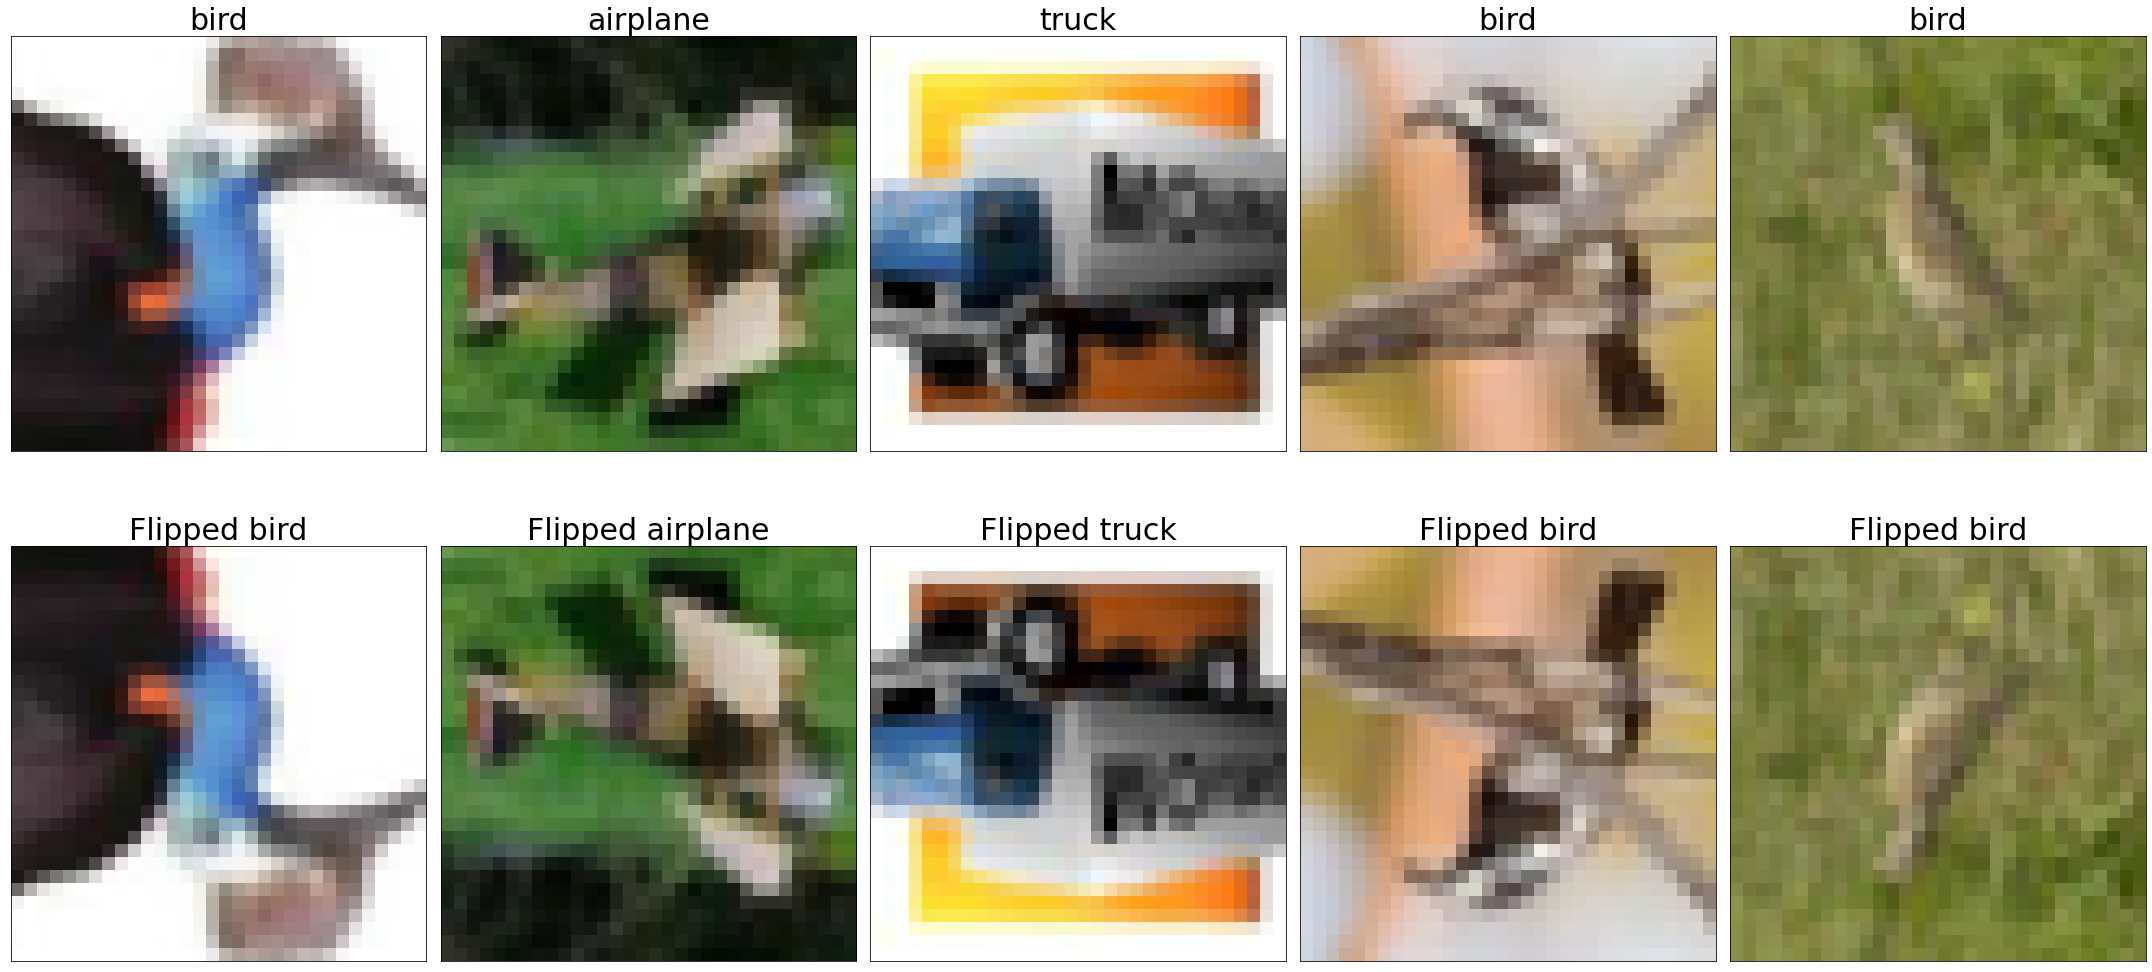

In [12]:
from torchvision.transforms import RandomVerticalFlip

# load test set
dataset = CIFAR10(root='.', train=True, transform=ToTensor())
loader = DataLoader(dataset, batch_size=15, shuffle=True)

# prepare a random flip
flip = RandomVerticalFlip(p=1) 

# load some data
for x, y in loader:
    break
    

# visualise the flipping
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(30, 15))

for img, label, ax in zip(x, y, axes[0]):
    ax.imshow(np.transpose(img, (1, 2, 0)))
    ax.set_title(f"{dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])
    
for img, label, ax in zip(x, y, axes[1]):
    ax.imshow(np.transpose(flip(img), (1, 2, 0)))
    ax.set_title(f"Flipped {dataset.classes[label]}", fontdict={'size': 30})
    ax.set_xticks([])
    ax.set_yticks([])


fig.tight_layout()

### Zadanie 2. Augmentacja danych (1 pkt.)

Używając funkcjonalności dostępnych w [`torchvision.transforms`](https://pytorch.org/docs/stable/torchvision/transforms.html) dodaj augmentacje danych do datasetu treningowego, zobacz o ile poprawia to wynik twojego modelu z poprzedniego zadania. W razie wątpliwości najlepiej przeszukać internet w poszukiwaniu typowych augmentacji dla CIFAR10.

In [27]:
from torchvision.transforms import Compose, ToTensor, RandomHorizontalFlip, ColorJitter, GaussianBlur

In [33]:
# tutaj dodaj wybrane augumentcje danych treningowych i załaduj testowe
transforms = Compose([
    ToTensor(),
    RandomHorizontalFlip(p=0.5),
    ColorJitter(brightness=0.2, contrast=0.1, saturation=0.1, hue=0.2),
    # GaussianBlur(3)
])

train_dataset = CIFAR10(root='.', 
                        train=True,
                        download=True,
                        transform=transforms
                        )

test_dataset = CIFAR10(root='.', 
                       train=False,
                       download=True,
                       transform=transforms
                       )

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=5000, shuffle=False, num_workers=4)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


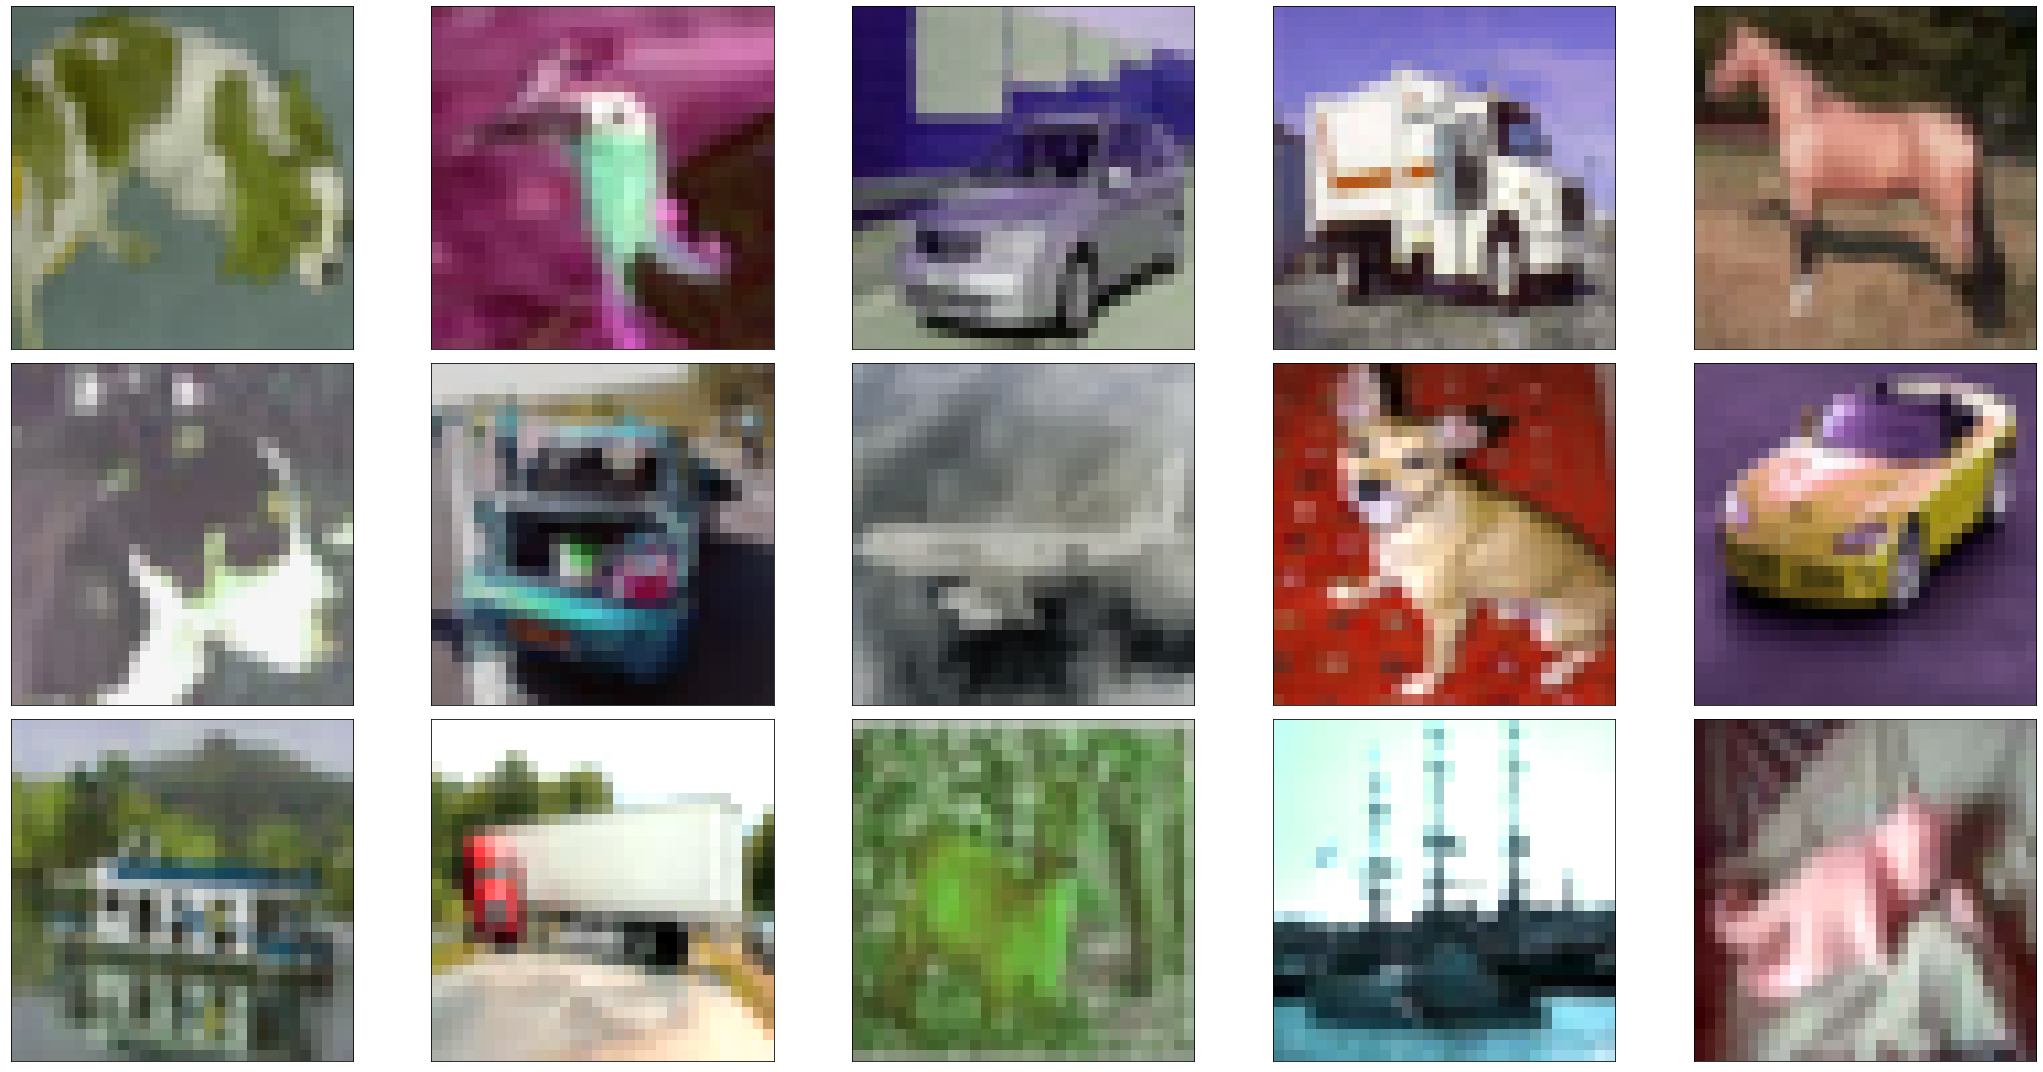

In [34]:
x, _ = next(iter(train_loader))

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(30, 15))
for i, row in enumerate(axes):
    for j, ax in enumerate(row):
      ax.imshow(np.transpose(x[i*5 + j], (1, 2, 0)))
      ax.set_xticks([])
      ax.set_yticks([])
fig.tight_layout()

In [35]:
MODEL_PATH = 'CifarClassifierWithAugmentation'
METRICS_PATH = 'metrics-with-augmentation.pkl'

In [37]:
# define model
classifier = CifarClassifier(batch_size)
classifier.to(device)
optimizer = torch.optim.Adam(params=classifier.parameters(), lr=0.001)
loss_func = torch.nn.CrossEntropyLoss()

metrics = {'train_loss': [], 'train_accuracy': [], 'test_loss': [], 'test_accuracy': []}

In [38]:
# tutaj powtórz pętle uczenia z poprzedniego zadania
# tutaj zaimplementuj pętle uczenia ze wszystkimi potrzebnymi hiperparametrami
patience = 5
early_stoping_triggers = 0
last_loss = float('inf')

training_finished = False
epochs_num = 50
epoch = 0

while not training_finished and epoch < epochs_num:
  epoch += 1

  train_accuracy = []
  train_loss = []
  for x, y in train_loader:
    x = x.to(device)
    y = y.to(device)

    optimizer.zero_grad()
    # evaluate
    output = classifier(x)
    loss = loss_func(output, y)
    # save metrics
    train_loss.append(loss)
    train_accuracy.append(torch.sum(torch.argmax(output, dim=1) == y) / train_loader.batch_size)
    # correct network
    loss.backward()
    optimizer.step()
  
  metrics['train_loss'].append(sum(train_loss) / len(train_loader))
  metrics['train_accuracy'].append(sum(train_accuracy) / len(train_loader))

  print(f'epoch: {epoch}')
  print(f'train accuracy: {metrics["train_accuracy"][-1]}')
 
  test_accuracy = []
  test_loss = []
  for x, y in test_loader:
    x = x.to(device)
    y = y.to(device)

    with torch.no_grad():
      output = classifier(x)
      loss = loss_func(output, y)

      test_loss.append(loss)
      test_accuracy.append(torch.sum(torch.argmax(output, dim=1) == y) / test_loader.batch_size)

  metrics['test_loss'].append(sum(test_loss) / len(test_loader))
  metrics['test_accuracy'].append(sum(test_accuracy) / len(test_loader))

  print(f'test accuracy: {metrics["test_accuracy"][-1]}')

  if metrics['test_loss'][-1] > last_loss:
    early_stoping_triggers += 1
    if early_stoping_triggers > patience:
      training_finished = True
  else:
    early_stoping_triggers = 0
  last_loss = metrics['test_loss'][-1]

  if epoch % 5 == 0:
    torch.save(classifier.state_dict(), MODEL_PATH)
    with open(METRICS_PATH, "wb") as f:
      pickle.dump(metrics, f)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


epoch: 1
train accuracy: 0.375
test accuracy: 0.45579999685287476
epoch: 2
train accuracy: 0.4898097813129425
test accuracy: 0.5037999749183655
epoch: 3
train accuracy: 0.5446770787239075
test accuracy: 0.5568000078201294
epoch: 4
train accuracy: 0.5765665173530579
test accuracy: 0.5936999917030334
epoch: 5
train accuracy: 0.6024616360664368
test accuracy: 0.6092000007629395
epoch: 6
train accuracy: 0.6144500970840454
test accuracy: 0.6238999962806702
epoch: 7
train accuracy: 0.6351302862167358
test accuracy: 0.6363999843597412
epoch: 8
train accuracy: 0.644501268863678
test accuracy: 0.6328999996185303
epoch: 9
train accuracy: 0.6501558423042297
test accuracy: 0.6521999835968018
epoch: 10
train accuracy: 0.6616647839546204
test accuracy: 0.6584999561309814
epoch: 11
train accuracy: 0.6708759665489197
test accuracy: 0.6650999784469604
epoch: 12
train accuracy: 0.6707161068916321
test accuracy: 0.6606000065803528
epoch: 13
train accuracy: 0.6795476078987122
test accuracy: 0.677799999713

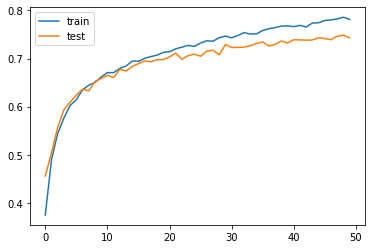

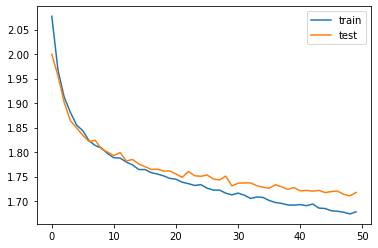

In [39]:
plt.plot(metrics['train_accuracy'], label='train')
plt.plot(metrics['test_accuracy'], label='test')
plt.title='accuracy'
plt.legend()
plt.show()

plt.plot(metrics['train_loss'], label='train')
plt.plot(metrics['test_loss'], label='test')
plt.title='loss'
plt.legend()
plt.show()

## Ataki Adwersarialne

Jednym z (ciągle nierozwiązanych) problemów w sieciach neuronowych, zwłaszcza systemów wizyjnych są tzw. ataki adwersarialne. Przy takim ataku, "agresor" ma pewien ograniczony dostęp do modelu (np. dostęp do logitów na wyjściu sieci) i używając tych informacji jest w stanie tak zmodyfikować wejście do sieci w takim sposób aby uzyskać błędne, a nawet specyficzne, wyjście. Poniższy kod prezentuje metodę **F**ast **G**radient **S**ign **M**ethod, która modyfikuje wejście do sieci za pomocą gradientu funkcji kosztu po tym wejściu.

<font size=4>$$ \hat{x} = x + \epsilon \space \textit{sign}\big(\nabla_x \mathcal{L}(x, y)\big) $$ </font>

In [40]:
from torchvision.models import inception_v3
from torchvision.transforms import Compose, Resize, ToTensor
import torch.nn as nn
import numpy as np

from PIL import Image
import urllib.request
import io
import json 

In [41]:
# cast to tensor and resize to for inception v3
preprocess = Compose([Resize((299,299)), ToTensor()])

# some prepared images
img_names = ['bird.jpg', 'cat.jpg', 'dog.jpg', 'frog.jpg']
imgs_url = 'https://raw.githubusercontent.com/gmum/ml2021-22/master/lab/resources/'

# get images 
imgs = []
for img_name in img_names:
    url = imgs_url + '/' + img_name
    with urllib.request.urlopen(url) as u:
        f = io.BytesIO(u.read())

    img = preprocess(Image.open(f))
    imgs.append(img)
    
imgs = torch.stack(imgs)

# get ImageNet classes list
labels_url = 'https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json'
with urllib.request.urlopen(labels_url) as url:
    s = url.read().decode("utf-8")
    labels = json.loads(s)

Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


  0%|          | 0.00/104M [00:00<?, ?B/s]

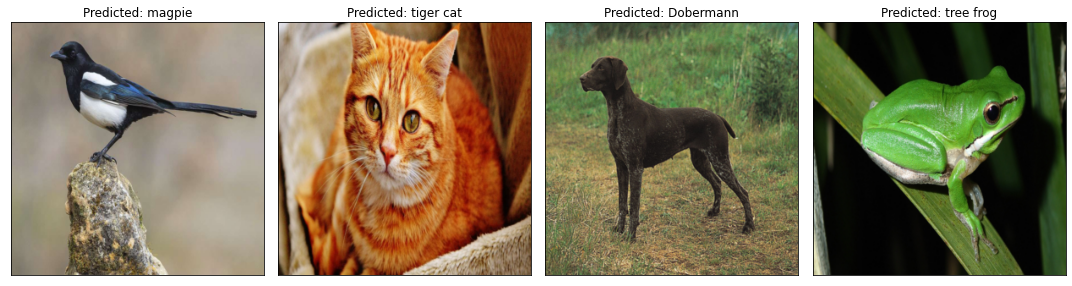

In [42]:
# load inception model 
model = inception_v3(pretrained=True) 
# set to eval, we don't want to modify it
model.eval()

# run the images through the model
output = model(imgs)
pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(15, 15))
for ax, img, p in zip(axes, imgs, pred):
    ax.imshow(np.transpose(img.detach(), (1,2,0)))
    ax.set_title(f"Predicted: {labels[p]}")
    ax.set_xticks([])
    ax.set_yticks([])
    
fig.tight_layout()

In [43]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

# eps parameter for the FGSM
eps = 0.02

# inputs need to have gradients enabled!
imgs.requires_grad = True

# run the model and calculate the loss
outputs = model(imgs)
cost = loss(outputs, pred)

# get input gradients
grad = torch.autograd.grad(cost, imgs, create_graph=False)[0]

# FGSM 
adv_imgs = imgs + eps * grad.sign()
# clamp to the image range
adv_imgs = torch.clamp(adv_imgs, min=0, max=1).detach()
# save gradients for visualisation
grads = torch.clamp(grad.sign(), min=0, max=1).detach()

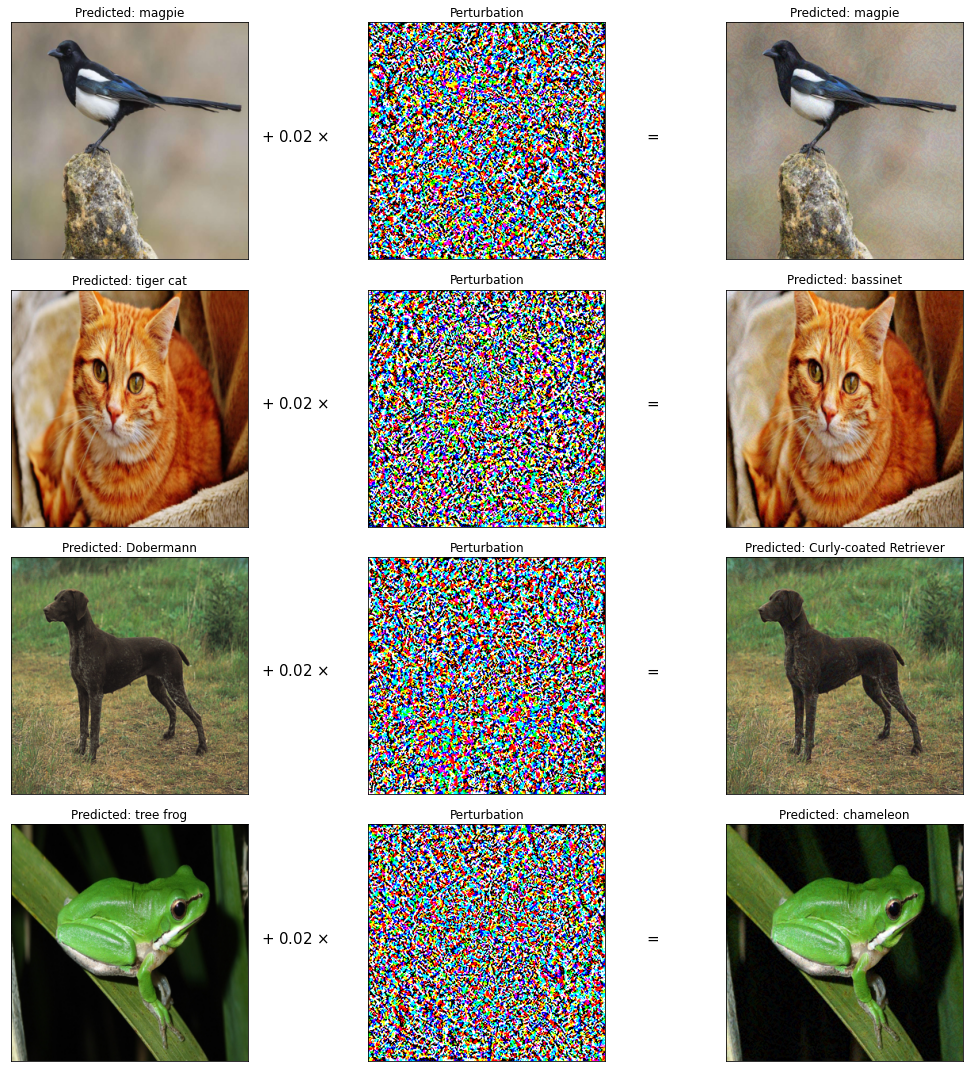

In [44]:
# run the advesarial samples through the network
output = model(adv_imgs)
adv_pred = torch.argmax(output, 1)

# visualisation
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(15, 15))
for row, img, adv, p, adv_p, g in zip(axes, imgs, adv_imgs, pred, adv_pred, grads):
    row[0].imshow(np.transpose(img.detach(), (1,2,0)))
    row[0].set_title(f"Predicted: {labels[p]}")
    row[0].set_xticks([])
    row[0].set_yticks([])
    
    row[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=row[0].transAxes)
    
    row[1].imshow(np.transpose(g, (1,2,0)))
    row[1].set_title(f"Perturbation")
    row[1].set_xticks([])
    row[1].set_yticks([])
    
    row[1].text(1.2,0.5, "=", size=15, ha="center", transform=row[1].transAxes)
    
    row[2].imshow(np.transpose(adv.detach(), (1,2,0)))
    row[2].set_title(f"Predicted: {labels[adv_p]}")
    row[2].set_xticks([])
    row[2].set_yticks([])
    
fig.tight_layout()

### Zadanie 3. Przykłady Adwersarialne (2 pkt.)
1. Zobacz dla jakiego $\epsilon$ metoda FGSM zmieni predykcje dla Sroki z powyższego przykładu.
2. Zastosuj metodę FGSM dla swojego modelu i 4 losowych przykładów z CIFAR10 tak aby uzyskać wizualizacje podobną do powyższej.

`HINT`: Normalizacja, której normalnie używamy sprawia, że obrazki wychodzą poza typowe $[0, 1]$, można rozwiązać ten problem na dwa sposoby: <br> 1) "odwrócić" normalizację znając użyte średnią i odchylenie standardowe, <br> 2) nie używać normalizacji

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [58]:
# prepare loss function for the method
loss = nn.CrossEntropyLoss()

magpie = torch.unsqueeze(imgs[0], 0)
# magpie.requires_grad = True

output = model(magpie)
pred = torch.argmax(output, 1)
cost = loss(output, pred)

# get input gradients
grad = torch.autograd.grad(cost, magpie, create_graph=False)[0]

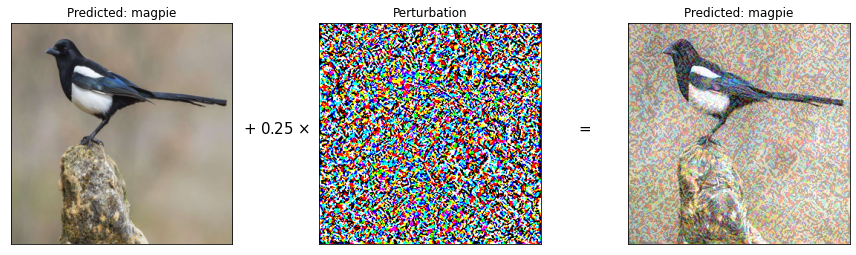

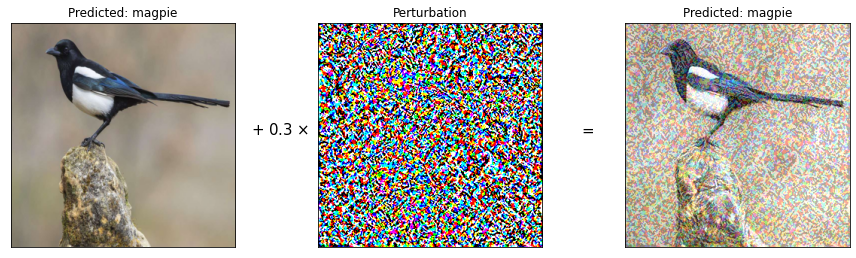

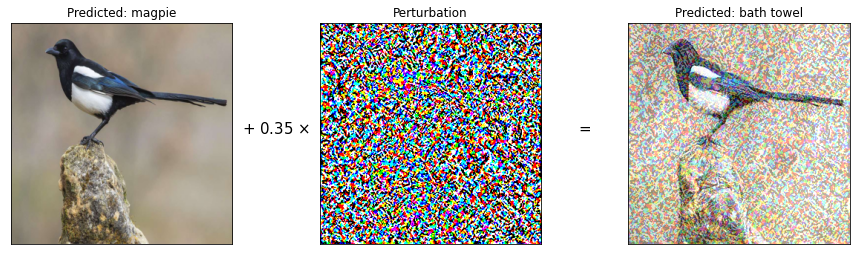

In [86]:
# eps parameter for the FGSM
eps = 0.2

adv_pred = pred
while adv_pred == pred:
  eps += 0.05
  # FGSM 
  adv_magpie = magpie + eps * grad.sign()
  # clamp to the image range
  adv_magpie = torch.clamp(adv_magpie, min=0, max=1).detach()
  # save gradients for visualisation
  grad = torch.clamp(grad.sign(), min=0, max=1).detach()

  # run the advesarial samples through the network
  output = model(adv_magpie)
  adv_pred = torch.argmax(output, 1)

  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(12, 12))

  axes[0].imshow(np.transpose(magpie[0].detach(), (1,2,0)))
  axes[0].set_title(f"Predicted: {labels[pred]}")
  axes[0].set_xticks([])
  axes[0].set_yticks([])

  axes[0].text(1.2,0.5, fr"+ {eps} $\times$", size=15, ha="center", transform=axes[0].transAxes)

  axes[1].imshow(np.transpose(grad[0], (1,2,0)))
  axes[1].set_title(f"Perturbation")
  axes[1].set_xticks([])
  axes[1].set_yticks([])

  axes[1].text(1.2,0.5, "=", size=15, ha="center", transform=axes[1].transAxes)

  axes[2].imshow(np.transpose(adv_magpie[0].detach(), (1,2,0)))
  axes[2].set_title(f"Predicted: {labels[adv_pred]}")
  axes[2].set_xticks([])
  axes[2].set_yticks([])
  fig.tight_layout()
  plt.show()

In [ ]:
# tutaj załaduj 4 losowe przykłady ze zbioru testowego, uważaj na normalizacje!

In [ ]:
# tutaj zastosuj metode FGSM do wygenerowania przykładów adwersarialnych

In [ ]:
# tutaj przetestuj swój model i użyj wizualizacji z powyższego przykładu